In [201]:
# model test
import pickle
with open('p_file/input.p','rb') as f:
     data_input = pickle.load(f)

# replace missing value
import pandas as pd
import numpy as np
# np.random.seed(5599)
df_mv = data_input.replace(0, np.nan)
df_replace = df_mv.replace(np.nan, df_mv.dropna().mean())

# split the testing and training data
s = np.random.rand(len(data_input)) < 0.8
train_df = df_replace[s]
test_df =  df_replace[~s]

# normalization and build the tree
import sklearn
import os
from sklearn import tree
from os import system
from sklearn.tree import DecisionTreeClassifier

Y = train_df['label']
X = train_df.drop('label', 1)

B = test_df['label']
A = test_df.drop('label', 1)

A_norm = (A - A.mean()) / (A.max() - A.min())
X_norm = (X - X.mean()) / (X.max() - X.min())

In [202]:
# set baseline model-linear SVM and test precision
from sklearn.metrics import precision_score, confusion_matrix, precision_recall_curve
from sklearn import svm,linear_model
import seaborn as sn
import matplotlib.pyplot as plt
from itertools import cycle

lin_clf = svm.LinearSVC()
lin_clf.fit(X_norm, Y) 
B_pred_linear = lin_clf.fit(X_norm, Y).predict(A_norm)
cm_linear = confusion_matrix(B, B_pred_linear)
precision_linear = precision_score(B, B_pred_linear,labels=[3], pos_label=3,average=None)
print ('confusion_matrix_linear={}'.format(cm_linear),'precision_linear={}'.format(precision_linear))

confusion_matrix_linear=[[17 13  1]
 [ 5 19 10]
 [ 2  7 21]] precision_linear=[ 0.65625]


/Users/IsabelTxx/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1023: UserWarning: Note that pos_label (set to 3) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


In [203]:
# test different models
# first test SVM-rbf
import math
c = []
for i in range(-8,2,1):
    c.append(math.pow(10,i))
    
prec_svm = 0
for i in c:
    clf_best = svm.SVC(C=i,decision_function_shape='ovr',probability=True)
    clf_best = clf_best.fit(X_norm, Y)
    B_predict_svm = clf_best.fit(X_norm, Y).predict(A_norm)
    prec_rbf = precision_score(B, B_predict_svm,labels=[3], pos_label=3,average=None)
    if prec_rbf > prec_svm:
        prec_svm = prec_rbf
        C_best = i
        clf_rbf=clf_best
print (clf_rbf)

/Users/IsabelTxx/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1023: UserWarning: Note that pos_label (set to 3) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/Users/IsabelTxx/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [204]:
prec_svm

array([ 0.63333333])

In [205]:
# then test the svm[ploy], with degree and c that provide best precision
Degree = [2,3,4,5,6]
prec_svmpoly = 0
for m in c:
    for f in Degree: 
        clf2 = svm.SVC(C=i,kernel='poly', degree=f, decision_function_shape='ovr',probability=True)
        clf2 = clf2.fit(X_norm, Y)
        B_predict_poly = clf2.fit(X_norm, Y).predict(A_norm)
        precpoly = precision_score(B, B_predict_poly,labels=[3], pos_label=3,average=None)
        if precpoly > prec_svmpoly:
            prec_svmpoly = precpoly
            C_poly_best = m
            clf_poly=clf2
print (clf_poly)

/Users/IsabelTxx/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1023: UserWarning: Note that pos_label (set to 3) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/Users/IsabelTxx/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC(C=250, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='auto', kernel='poly',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [206]:
# test decision tree, find the best precision for decision tree
min_samples_split_values = [50,100,150,200,250]
min_samples_leaf_values = [10,20,40,80,100]

splits = min_samples_split_values
leaves = min_samples_leaf_values

def testTrees2(X_train, y_train, X_test, y_test,split,leaf, auc):
    clf = DecisionTreeClassifier(criterion='entropy',min_samples_split=split,min_samples_leaf=leaf)
    clf = clf.fit(X_train, y_train)
    if (auc==0):
        cm = confusion_matrix(y_test, clf.predict(X_test))
        accuracy= (cm[0,0]+cm[1,1]+cm[2,2])/cm.sum()
        return accuracy
    else:
        return precision_score(y_test, clf.predict(X_test),labels=[3], pos_label=3,average=None)

/Users/IsabelTxx/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1023: UserWarning: Note that pos_label (set to 3) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


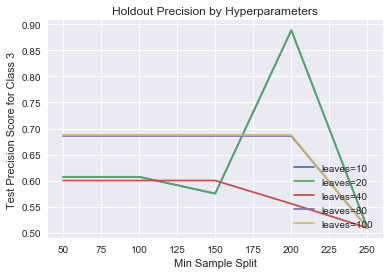

In [207]:

%matplotlib inline

run=1
if (run == 1):
    res =dict()
    for leaf in leaves:
        res[leaf]= list()
    for leaf in leaves:
        for split in splits:
            res[leaf].append(testTrees2(X_norm,Y,A_norm,B,split,leaf,1))   
    
fig = plt.figure()
ax=fig.add_subplot(111)
for i in range(0,5):
    plt.plot(splits,res[leaves[i]], label = 'leaves={}'.format(leaves[i]))

plt.legend(loc = 4)
ax.set_xlabel('Min Sample Split')
ax.set_ylabel('Test Precision Score for Class 3')
plt.title('Holdout Precision by Hyperparameters')

In [208]:
prec_dt = 0

for i in splits:
    for j in leaves:
        dt_best = DecisionTreeClassifier(criterion='entropy',min_samples_split=i,min_samples_leaf=j)
        dt_best = dt_best.fit(X_norm, Y)
        t_precision= precision_score(B, dt_best.predict(A_norm),labels=[3], pos_label=3,average=None)
        if t_precision > prec_dt:
            prec_dt = t_precision
            best_split=i
            best_leaves=j
            dt2=dt_best
print (dt2)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


/Users/IsabelTxx/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1023: UserWarning: Note that pos_label (set to 3) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


In [209]:
prec_dt

array([ 0.88888889])

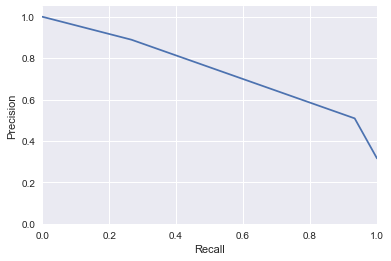

In [210]:
# plot precision_recall curve for decision tree
precision, recall, thresholds = precision_recall_curve(B, dt2.predict(A_norm), pos_label=3)

plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

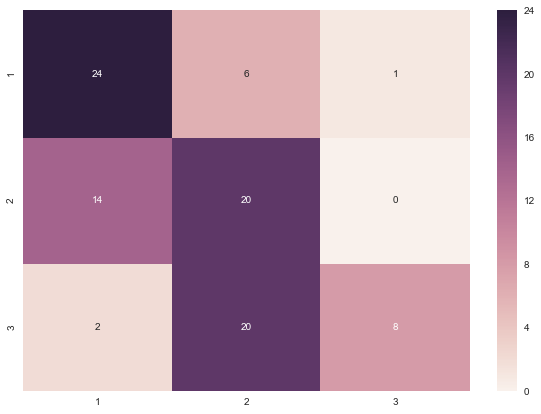

In [211]:
# plot confusion matrix for decision tree
B_pred_best = dt2.predict(A_norm)
cm_best = confusion_matrix(B, B_pred_best)

import seaborn as sn
df_cm_best = pd.DataFrame(cm_best, index = [i for i in range(1,4)],columns = [i for i in range(1,4)] )


plt.figure(figsize = (10,7))
sn.heatmap(df_cm_best, annot=True)

In [212]:
precision_score(B, dt2.predict(A_norm),average=None)

array([ 0.6       ,  0.43478261,  0.88888889])

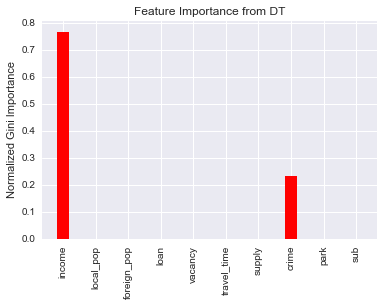

In [213]:
# plot 
fig, ax = plt.subplots()
width = 0.35
ax.bar(np.arange(10), dt2.feature_importances_, width, color = 'r')
ax.set_xticks(np.arange(len(dt2.feature_importances_)))
ax.set_xticklabels(X_norm.columns.values, rotation = 90)
plt.title('Feature Importance from DT')
ax.set_ylabel('Normalized Gini Importance')

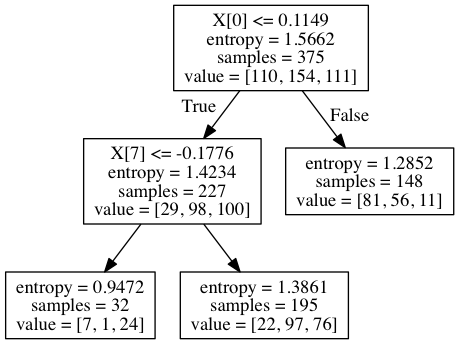

In [214]:
# plot the tree
from IPython.display import Image, display
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from pydotplus import *

dot_data = tree.export_graphviz(dt2, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png()) 